# Image Captioning Models for Flashcard Question Generation from PDF Slides

In this Notebook, the Image captioning models:
- nlpconnect/vit-gpt2-image-captioning: [huggingface](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning), [original block post](https://ankur3107.github.io/blogs/the-illustrated-image-captioning-using-transformers/)

are implemented and Fine-Tuned for Flashcard Question Generation on the synthetic Anki Data PDF Slide deck.
- The model has been chosen, because it is the most used / downloaded image captioning model on huggingface
- The model needs to be presented. Additional useful references:
- [VIT Paper](https://arxiv.org/abs/2010.11929)
- [Blog Post about VIT](https://theaisummer.com/vision-transformer/)
- [GPT-2 explained](http://jalammar.github.io/illustrated-gpt2/), in general this guy has an awesome series of block posts about transformers and attention if further explanations are needed
- [GPT-2 release paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

## nlpconnect/vit-gpt2-image-captioning

### Inference example from Huggingface:

In [ ]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [7]:
max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

In [1]:

image_paths = ['./datasets/examples/bruchtal.jpeg', './datasets/examples/ducks.jpeg', './datasets/examples/Jacobian.png']
predictions = predict_step(image_paths) # ['a woman in a hospital bed with a woman in a hospital bed']


2023-07-12 16:05:01.095370: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 16:05:01.142739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 16:05:02.355136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.9.crossattention.masked_bias', 'decoder.transformer.h.8.attn.bias', 'decoder.transformer.h

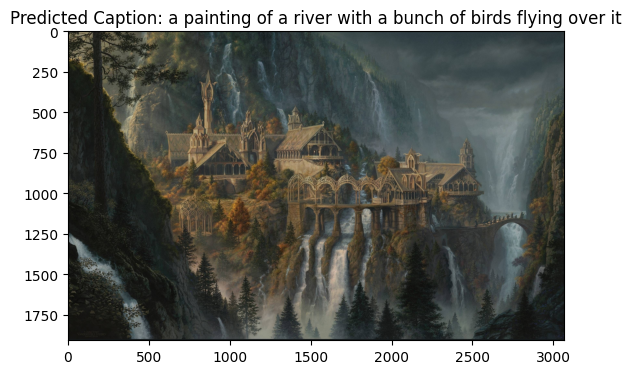

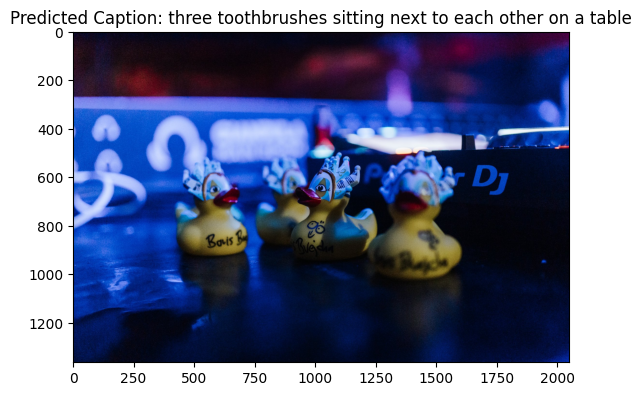

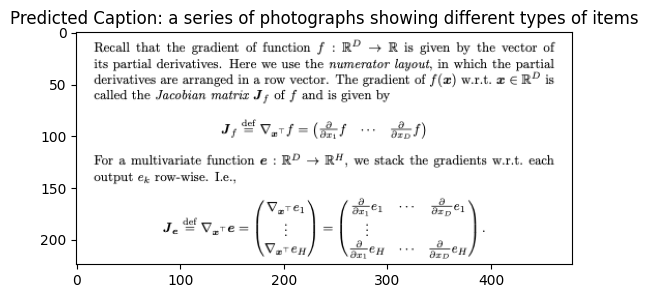

In [2]:
# Printing the images with the captions
import matplotlib.pyplot as plt
import numpy as np

for i, image in enumerate(image_paths):
    img = Image.open(image)
    img_arr = np.asarray(img)
    plt.imshow(img_arr)
    plt.title(f"Predicted Caption: {predictions[i]}")
    plt.show()

### Data Preprocessing
I wrote a Datapreprocessing class for this model, in order to be able to reuse it better in the long term. This class, extracts images from the pdfs using the extractor, creates train, test and validations splits, and saves each split in its own directory, along with a metadata csv, which includes the labels for each image. Besides that, the class also converts the data into a usable huggingface dataset and preprocesses the input and output data with the correct image-preprocessor and tokenizer. The User has to inherit from this class and define for each dataset its own class that overwrites the build_metadata_csv, as each dataset can come in its own format, that has to be converted to the required format of the metadata.csv. For more info look at the class implementation here: src/image_to_text/data_preprocessing/vit_gpt2.py
- The resulting metadata csv should only include 2 columns, Question, filename

#### Synthetic Data

In [3]:
from src.image_to_text.data_preprocessing.vit_gpt2 import VitGPT2Dataset
from typing import List, Union
import os
import pandas as pd
import swifter
from bs4 import BeautifulSoup

class VitGPT2Synthetic(VitGPT2Dataset):
    """
    Dataset class for the synthetically generated slides
    """
    
    def __init__(self, slide_path: Union[str, List[str]], dataset_path='datasets/synthetic_slides/', max_target_length=128):
        super().__init__(slide_path, dataset_path, max_target_length)
    
    def build_metadata_csv(self, split_path: str, split_page_numbers: List[int]):
        
        df = pd.read_csv("datasets/synthetic_slides/data.csv")[:230] # for debugging purposes i only use the first 230 slides
        
        # duplicate entrys, as multiple samples have the same target but a different input -> The pdfs only differ in the style of the slide template, so the same page number in every pdf has the same target but the input looks different -> duplicate the target data so that it aligns with the number of pdfs used
        df = pd.concat([df, pd.read_csv("datasets/synthetic_slides/data.csv")[:230]]).reset_index(drop=True)
        
        # filter to include only the pages of the needed split
        df = df.loc[split_page_numbers]
        
        df["Page Number"] = df.index
        
        # extract questions from nflds
        df["Question"] = df["nflds"].swifter.apply(lambda x: x.split("',")[0].strip("[").strip("'") if "'," in x else x.split('",')[0].strip("[").strip('"'))
        
        # remove html tags
        df["Question"] = df["Question"].swifter.apply(lambda x: BeautifulSoup(x, features="lxml").text)
        
        # replace empty question with NAN, so that they can automatically be filtered
        df.replace('', pd.NA, inplace=True)
        
        df["file_name"] = [f"slide_{i}.png" for i in df.index]
        df.drop(columns=["nid", "nflds", "answer", "images"], inplace=True)
        df.dropna(inplace=True)
        
        df.to_csv(os.path.join(split_path, "metadata.csv"), index=False)
        return df

In [4]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

# initialize model, image-preprocessor/feature_extractor and tokenizer
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning") # read more about image processor / feature extractor here: https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTImageProcessor
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

synthetic_slides = VitGPT2Synthetic(slide_path=["datasets/synthetic_slides/pdf/render_2_230.pdf", "datasets/synthetic_slides/pdf/render_6_230.pdf"])

synthetic_slides.build_dataset(feature_extractor, tokenizer)

Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.8.crossattention.bias', 'decoder.transformer.h.4.attn.bias', 'decoder.transformer.h.7.attn.masked_bias', 'decoder.transformer.h.0.attn.bias', 'decoder.transformer.h.8.attn.masked_bias', 'decoder.transformer.h.3.attn.bias', 'decoder.transformer.h.4.attn.masked_bias', 'decoder.transformer.h.10.attn.bias', 'decoder.transformer.h.1.crossattention.bias', 'decoder.transformer.h.1.crossattention.masked_bias', 'decoder.transformer.h.7.crossattention.bias', 'decoder.transformer.h.7.crossattention.masked_bias', 'decoder.transformer.h.11.attn.masked_bias', 'decoder.transformer.h.1.attn.bias', 'decoder.transformer.h.0.crossattention.bias', 'decoder.transformer.h.2.attn.bias', 'decoder.transformer.h.10.crossattention.masked_bias', 'decoder.transformer.h.3.crossattention.bias', 'decoder.transformer.h.7.attn.bias', 'decoder.transformer.h.11.at

Pandas Apply:   0%|          | 0/276 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/276 [00:00<?, ?it/s]

/scratch/slurm_tmpdir/job_22434276/ipykernel_29676/3270792239.py:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df["Question"] = df["Question"].swifter.apply(lambda x: BeautifulSoup(x, features="lxml").text)


Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

/scratch/slurm_tmpdir/job_22434276/ipykernel_29676/3270792239.py:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df["Question"] = df["Question"].swifter.apply(lambda x: BeautifulSoup(x, features="lxml").text)


Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

/scratch/slurm_tmpdir/job_22434276/ipykernel_29676/3270792239.py:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df["Question"] = df["Question"].swifter.apply(lambda x: BeautifulSoup(x, features="lxml").text)
100%|██████████| 91/91 [00:01<00:00, 68.85it/s]


Resolving data files:   0%|          | 0/276 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/92 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/93 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/ma/ma_ma/ma_lknorr/.cache/huggingface/datasets/imagefolder/default-2ec854d2abea6f2d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/275 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Map:   0%|          | 0/92 [00:00<?, ? examples/s]

In [5]:
synthetic_slides.dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 275
    })
    validation: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 91
    })
    test: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 92
    })
})

### Master Labeling Slides

In [ ]:
from src.image_to_text.data_preprocessing.vit_gpt2 import VitGPT2Dataset
from typing import List
import os
import pandas as pd

# same as with the other datasets, just that the csv conversion is again different
class VitGPT2MasterDataset(VitGPT2Dataset):

    def __init__(self, slide_folder_path: str, dataset_path='datasets/master/', max_target_length=128):
        slide_path = [os.path.join(slide_folder_path, pdf_name) for pdf_name in pd.read_csv("datasets/master/Dataset_Master.csv")["PDF-Name"].unique()] # Setting an explicit order of the pdf-slides, so that the order is fixed and lines up with the .csv file later
        super().__init__(slide_path, dataset_path, max_target_length)

    def build_metadata_csv(self, split_path: str, split_page_numbers: List[int]):

        master_df = pd.read_csv("datasets/master/Dataset_Master.csv")
        master_df["Page Number"] = master_df.index # resetting page numbers, as all pdfs got concatenated into a huge one, with a fixed order, that ligns up with the reset
        master_df = master_df.dropna(subset="Question 1").drop(columns=["Topic", "Marked for processing", "Includes Image Data", "Includes formula", "Type of Question", "Comment", 'Title of the slide', 'PDF-Name']) # drop unnecessary data
        master_df = master_df.melt(id_vars=['Page Number'], value_name='Question', var_name='Column').sort_values(by=['Page Number']) # Transform every question into a seperate sample for the same page number
        master_df = master_df.dropna(subset="Question").drop(columns=['Column']) # drop empty values from conversion

        # format csv correctly
        master_df["Page Number"] = master_df["Page Number"].astype(int)
        master_df["file_name"] = master_df["Page Number"].apply(lambda nr: f"slide_{int(nr)}.png")
        master_df = master_df[master_df["Page Number"].isin(split_page_numbers)]
        master_df.to_csv(os.path.join(split_path, "metadata.csv"), index=False)
        return master_df

As with Apple VQG, the resolution problem is also persistened here, thats why we'd like to also train with a higher resolution. As explained in the ViT paper, the image will be divided into patches of size $p^2$, with the total number of patches being equal to the input sequence length. As transformers **in practice** have a maximum sequence length, in this case it is 1024, it constrains the maximum resolution we can use.
- In the following I'm calculating the maximum width and height, that still preserves our 16:9 ratio from the pdf-slides. Preserving the aspect ratio is important, as the text won't get squished etc.

For image resizing:
- $ N = HW/p^2 $
- as max_n should be 1024 or 512 -> $ N = 1024$
- $ 1024 * p^2 = HW = 1024 * 16^2 = 262144 $
- as we are dealing with pictures in 16:9 aspect ratio:
- $ HW = H^2 * (16 / 9) -> \lfloor \sqrt{HW / (16 / 9)} \rfloor = H -> W = \lfloor H * (16/9) \rfloor$
- Result: max height: 384, max width: 682
- As shown below, this improves the readability of text a lot

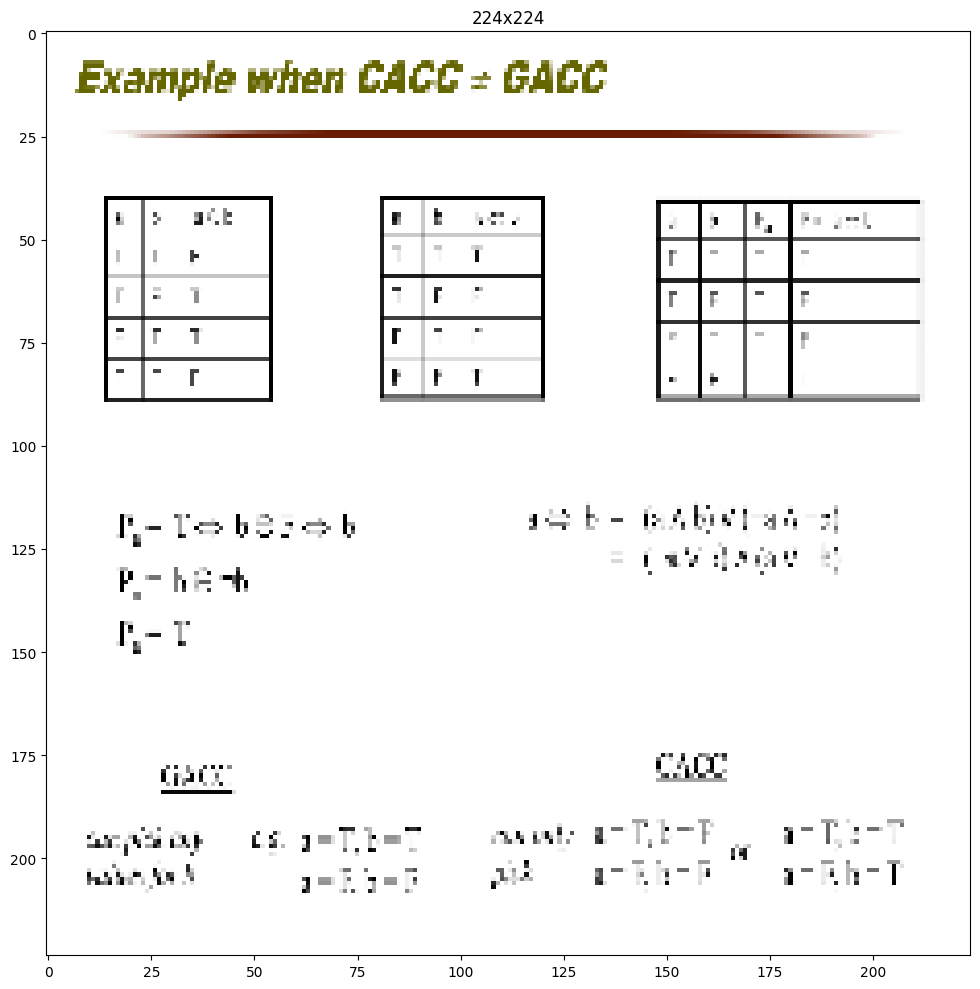

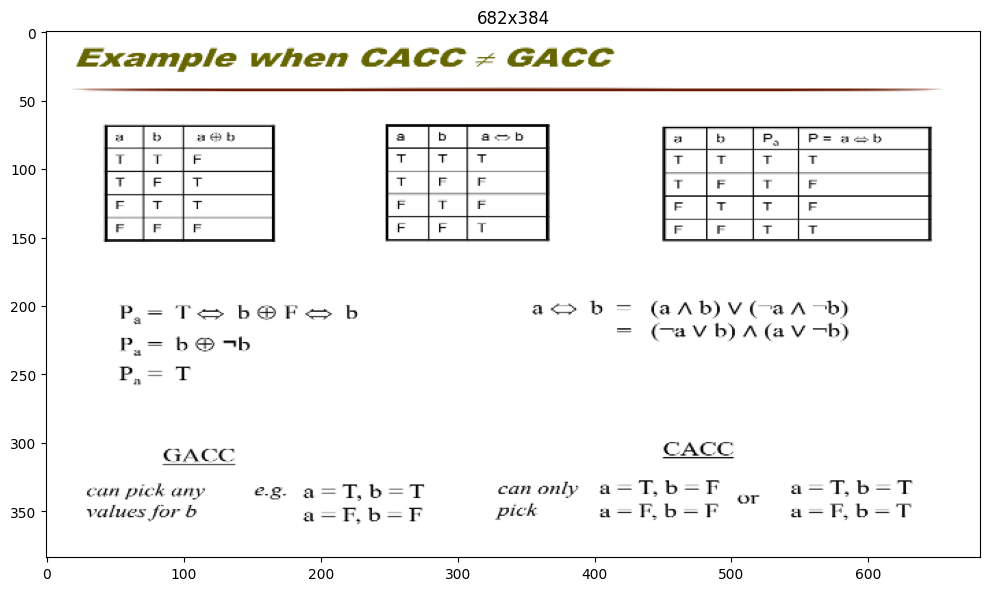

In [5]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("slide_101.png")
image = cv2.resize(image, (224,224))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title("224x224")
plt.tight_layout()
plt.savefig("224_resolution.png", dpi=150)
plt.show()

image = cv2.imread("slide_101.png")
image = cv2.resize(image, (682,384))
plt.figure(figsize=(10,7))
plt.imshow(image)
plt.title("682x384")
plt.tight_layout()
plt.savefig("628_resolution.png", dpi=150)
plt.show()

In [ ]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

master = VitGPT2MasterDataset(slide_folder_path="datasets/master")

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

master.load_prebuild_dataset(feature_extractor, tokenizer)
#master.build_dataset(feature_extractor, tokenizer)

In [ ]:
master.dataset

#### Gold Standard
- same thing as with the synthetic ones, but with the gold standard

In [1]:
# Gold Standard for test training

from src.image_to_text.data_preprocessing.vit_gpt2 import VitGPT2Dataset
from typing import List
import os
import pandas as pd

class VitGPT2GoldStandard(VitGPT2Dataset):
    
    def __init__(self, slide_path: str, dataset_path='datasets/gold_standard/', max_target_length=128):
        super().__init__(slide_path, dataset_path, max_target_length)
    
    def build_metadata_csv(self, split_path: str, split_page_numbers: List[int]):
        
        df = pd.read_csv("datasets/gold_standard/Goldstandard.csv")
        df.drop(columns=["PDF-Name", "Marked for processing", "Includes Image Data", "Comment"], inplace=True)
        df.dropna(inplace=True)
        
        df["Page Number"] = df["Page Number"].astype(int)
        df["file_name"] = df["Page Number"].apply(lambda nr: f"slide_{int(nr)}.png")
        df = df[df["Page Number"].isin(split_page_numbers)]
        df.to_csv(os.path.join(split_path, "metadata.csv"), index=False)
        return df

In [2]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

gold_standard = VitGPT2GoldStandard(slide_path="datasets/gold_standard/IT-Security_all_slides_no_duplicates.pdf")

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

gold_standard.load_prebuild_dataset(feature_extractor, tokenizer)
# gold_standard.build_dataset(feature_extractor, tokenizer)

2023-07-16 12:22:56.449293: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-16 12:22:56.493218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 12:22:57.469282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.5.crossattention.masked_bias', 'decoder.transformer.h.2.attn.masked_bias', 'decoder.transf

Resolving data files:   0%|          | 0/265 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/96 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/94 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/ma/ma_ma/ma_lknorr/.cache/huggingface/datasets/imagefolder/default-43dcb1205c8a56d6/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/ma/ma_ma/ma_lknorr/.cache/huggingface/datasets/imagefolder/default-43dcb1205c8a56d6/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-684d8476c6c1b3fe.arrow


Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Loading cached processed dataset at /home/ma/ma_ma/ma_lknorr/.cache/huggingface/datasets/imagefolder/default-43dcb1205c8a56d6/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-ebe4a8cdcc5cefb5.arrow


In [3]:
gold_standard.dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 264
    })
    validation: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 95
    })
    test: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 93
    })
})

### Fine-Tuning

In [6]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Setting Training Arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_checkpointing=False,
#    fp16=True, # Mixed Precision Training
    gradient_accumulation_steps=5,
    output_dir="./vit-gpt2-out"
)

In [ ]:
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union

import torch
from torch import nn
from torch.utils.data import Dataset

# overwriting trainer to enable interpolation of positional encodings for vit-gpt2, as it isn't supported by the default Seq2SeqTrainer
class InterpolatingTrainer(Seq2SeqTrainer):

    def __init__(
        self,
        model: Union["PreTrainedModel", nn.Module] = None,
        args: "TrainingArguments" = None,
        data_collator: Optional["DataCollator"] = None,
        train_dataset: Optional[Dataset] = None,
        eval_dataset: Optional[Union[Dataset, Dict[str, Dataset]]] = None,
        tokenizer: Optional["PreTrainedTokenizerBase"] = None,
        model_init: Optional[Callable[[], "PreTrainedModel"]] = None,
        compute_metrics: Optional[Callable[["EvalPrediction"], Dict]] = None,
        callbacks: Optional[List["TrainerCallback"]] = None,
        optimizers: Tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR] = (None, None),
        preprocess_logits_for_metrics: Optional[Callable[[torch.Tensor, torch.Tensor], torch.Tensor]] = None,
    ):
        super().__init__(model=model,
            args=args,
            data_collator=data_collator,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,
            model_init=model_init,
            compute_metrics=compute_metrics,
            callbacks=callbacks,
            optimizers=optimizers,
            preprocess_logits_for_metrics=preprocess_logits_for_metrics)

    def compute_loss(self, model, inputs, return_outputs=False):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.

        Subclass and override for custom behavior.
        """
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs, interpolate_pos_encoding=True)
        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            if unwrap_model(model)._get_name() in MODEL_FOR_CAUSAL_LM_MAPPING_NAMES.values():
                loss = self.label_smoother(outputs, labels, shift_labels=True)
            else:
                loss = self.label_smoother(outputs, labels)
        else:
            if isinstance(outputs, dict) and "loss" not in outputs:
                raise ValueError(
                    "The model did not return a loss from the inputs, only the following keys: "
                    f"{','.join(outputs.keys())}. For reference, the inputs it received are {','.join(inputs.keys())}."
                )
            # We don't use .loss here since the model may return tuples instead of ModelOutput.
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        return (loss, outputs) if return_outputs else loss

In [7]:
from transformers import default_data_collator

master.dataset.set_format(type='torch')
train_dataset=master.dataset["train"]
eval_dataset=master.dataset["validation"]

#train_dataset=synthetic_slides.dataset["train"]
#eval_dataset=synthetic_slides.dataset["validation"]

# train_dataset=gold_standard.dataset["train"]
# eval_dataset=gold_standard.dataset["validation"]

# initialize trainer and start training
trainer = InterpolatingTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator
)
trainer.train()
trainer.save_model("./vit-gpt2-out")

Epoch,Training Loss,Validation Loss
1,No log,0.352170
2,No log,0.292570
3,No log,0.275783


TrainOutput(global_step=207, training_loss=0.3528635144809594, metrics={'train_runtime': 124.5005, 'train_samples_per_second': 6.626, 'train_steps_per_second': 1.663, 'total_flos': 1.488827101741056e+17, 'train_loss': 0.3528635144809594, 'epoch': 3.0})

In [8]:
# Test for debugging

import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

model = trainer.model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_paths = ['./datasets/gold_standard/test/slide_10.png', './datasets/gold_standard/test/slide_13.png', './datasets/gold_standard/test/slide_126.png']
predictions = predict_step(image_paths)
for i, image in enumerate(image_paths):
    img = Image.open(image)
    img_arr = np.asarray(img)
    plt.imshow(img_arr)
    plt.title(f"Predicted Caption: {predictions[i]}")
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './datasets/gold_standard/test/slide_10.png'

## Evaluating the Fine-Tuning process on the labeled slides

- Evaluation of the higher resolution models isn't supported with the generate method by default, as the required optional argument isn't part of the signature of the models forward class, as it is covered in the additional kwargs of the function
- This leads to the problem, that the generate method validates the arguments of the models functions, and thus, if the interpolate_positional_encodings argument is passed to the generate function it aborts with an unsupported argument error
- to fix this, I'm overwriting the functions that determine the arguments for this check with a function with a signature that explicitly includes the argument, for the model instance. This overwrite is then only present for the instance of the model class and isn't generally overwritten

In [ ]:
def forward_with_encoder(pixel_values = None, decoder_input_ids = None, decoder_attention_mask = None, encoder_outputs = None, past_key_values = None, decoder_inputs_embeds = None, labels = None, use_cache = None, output_attentions = None, output_hidden_states = None, return_dict = None, interpolate_pos_encoding=False, **kwargs):
    return model.old_forward(pixel_values, decoder_input_ids, decoder_attention_mask, encoder_outputs, past_key_values, decoder_inputs_embeds, labels, use_cache, output_attentions, output_hidden_states, return_dict, **kwargs)

model.old_forward = model.forward
model.forward = forward_with_encoder

In [ ]:
import inspect
# check if signatures are correct
inspect.signature(model.forward)

In [ ]:
inspect.signature(model.old_forward)

In [16]:
from src.evaluation.eval_main import Metrics
import nltk
import torch
import pandas as pd

nltk.download('wordnet')

# model = trainer.model

model.to('cuda')

# transform dataset to evaluation format
master.dataset.set_format(type='torch')
test_meta = master.test_metadata.pivot_table(index='Page Number', values='Question', aggfunc=list)
references = [(idx, row["Question"]) for idx, row in test_meta.iterrows()]

# set parameters for beam_search
max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# extract the pixel values from the dataset
pixel_values = master.dataset["test"]["pixel_values"]

# manually generate batches for model output generation
slice_size = 4
batches = [pixel_values[i:i + slice_size] for i in range(0, len(pixel_values), slice_size)]
predictions = []

for batch in batches:
    batch = batch.to(device)
    output_ids = model.generate(batch, **gen_kwargs, interpolate_pos_encoding=True)

    # batch decode the returned tokens to strings
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    preds = [(master.test_metadata.iloc[i][0], [pred]) for i, pred in enumerate(preds)] # transform in evaluation format
    predictions += preds

# run evaluation
metrics = Metrics(save_to_file=True)

result = metrics.evaluate(model_output=predictions, references=references),

result = pd.DataFrame(
    result,
    index=["384x683-vit-gpt2-master-E-3"]
)
result.to_csv("out/eval/384x683-vit-gpt2-master-E-3.csv")
result

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ma/ma_ma/ma_lknorr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ma/ma_ma/ma_lknorr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,PUNCTUATION,rouge1_fmeasure,rouge1_precision,rouge1_recall,rouge2_fmeasure,rouge2_precision,rouge2_recall,rougeL_fmeasure,rougeL_precision,rougeL_recall,...,min_r,avg_f1,max_f1,min_f1,avg_cos_sim,max_cos_sim,min_cos_sim,avg_sem_meteor,max_sem_meteor,min_sem_meteor
vit-gpt2-gold-standard-E-3,5,0.192819,0.197896,0.213109,0.056786,0.053998,0.075024,0.189562,0.192519,0.210769,...,0.0,0.046313,0.444444,0.0,0.171308,0.709789,-0.019713,0.212779,0.595238,0.0
